In [1]:
import os
import importlib.util
import torch.distributed as dist
import torch
from data.builder import build_dataset
from models.detectors.zid_rcnn import ZidRCNN
from scripts import dist_util
from models.utils.data_container import collate
from functools import partial
from PIL import Image
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from models.utils.det_utils import batched_nms
import itertools
from PIL import Image


/home/minhnh/python_venv/cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.utils.det_utils import bbox2result, bbox2roi
from data.coco_api import COCO, COCOeval
from terminaltables import AsciiTable

In [3]:
def build_detector(model_cfg):
    model_cfg_ = model_cfg.copy()

    model_type = model_cfg_.pop('type') 
    assert model_type == 'ZidRCNN', f'{model_type} is not implemented yet.'
    return ZidRCNN(**model_cfg_)
    
def get_config_from_file(filename, mode):
    spec = importlib.util.spec_from_file_location(mode, filename)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    # Create a dictionary from module attributes
    config_dict = {key: getattr(module, key) for key in dir(module) if not key.startswith('__')}
    return config_dict

In [4]:
def test_batch_processing(batch):
    batch['obj_id'] = batch['id'][0]
    batch.pop('id')
    for k, v in batch.items():
        if k == 'img_metas':
            batch[k] = batch[k][0].data
        if k == 'img':
            batch[k] = [batch[k][0].data[0].to(device, non_blocking=True)]
        
        elif k in ['rgb', 'mask', 'traj']:
            batch[k] = batch[k].data.to(device, non_blocking=True)
    return batch

In [72]:
cfg = get_config_from_file('configs/test_conf.py', 'detection')
cfg.get('model')['train_cfg'] = None
# cfg = get_config_from_file('configs/train_detection_conf.py', 'detection')

In [73]:
dataset = build_dataset(cfg.get('data')['test'])
# dataset = build_dataset(cfg.get('data')['train'])

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [7]:
device = torch.device('cuda:4')

In [57]:
model = build_detector(cfg.get('model'))
# shared_drive_cv/FewshotObjectDetection/outputs/VoxDet_p1/iter_19201.pth
model_path = '/home/minhnh/project_drive/CV/FewshotObjectDetection/VoxDet-simplified/results/ckpt/model_ep10_061000.pt'
model.load_state_dict(
    torch.load(model_path, map_location="cpu")
)
model.CLASSES = dataset.CLASSES
device = torch.device('cuda:4')
model.to(device)
model.eval()
print('Loaded model')

load model from: torchvision://resnet50
LOAD Backbone ResNET50 torchvision://resnet50
Loaded model


In [74]:
data = torch.utils.data.DataLoader(dataset,
                                    batch_size=1,
                                    num_workers=2,
                                    shuffle=False,
                                    pin_memory=False,
                                    collate_fn=partial(collate, samples_per_gpu=1))

In [10]:
P1_base = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/'
obj_ids = os.listdir(P1_base)
support_data = dict(rgb=[], mask=[])
for obj_id in tqdm(sorted(obj_ids)):

    tar_path = os.path.join(P1_base, '{}'.format(obj_id))
    # try:
    #     os.remove(os.path.join(tar_path, 'info.npz'))
    # except:
    #     pass
    
    try:
        p1_data = np.load(os.path.join(tar_path, 'info224.npz'))
        print(tar_path)
        M = p1_data['rgb'].shape[0]
        support_data['rgb'].append(torch.from_numpy(p1_data['rgb'].astype(np.float32))[range(0, M, 16), :])
        support_data['mask'].append(torch.from_numpy(p1_data['mask'].astype(np.float32))[range(0, M, 16), :])
    except:
        continue
support_data['rgb'] = torch.stack(support_data['rgb']).to(device)
support_data['mask'] = torch.stack(support_data['mask']).to(device)

  0%|          | 0/24 [00:00<?, ?it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000001


  4%|▍         | 1/24 [00:00<00:20,  1.15it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000002


  8%|▊         | 2/24 [00:01<00:18,  1.22it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000003


 12%|█▎        | 3/24 [00:02<00:16,  1.28it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000004


 17%|█▋        | 4/24 [00:03<00:15,  1.31it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000005


 21%|██        | 5/24 [00:03<00:14,  1.32it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000006


 25%|██▌       | 6/24 [00:04<00:13,  1.31it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000007


 29%|██▉       | 7/24 [00:05<00:12,  1.31it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000008


 33%|███▎      | 8/24 [00:06<00:12,  1.30it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000009


 38%|███▊      | 9/24 [00:06<00:11,  1.32it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000010


 42%|████▏     | 10/24 [00:07<00:10,  1.34it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000011


 46%|████▌     | 11/24 [00:08<00:09,  1.34it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000012


 50%|█████     | 12/24 [00:09<00:08,  1.34it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000013


 54%|█████▍    | 13/24 [00:09<00:08,  1.32it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000014


 58%|█████▊    | 14/24 [00:10<00:07,  1.28it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000015


 62%|██████▎   | 15/24 [00:11<00:07,  1.27it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000016


 67%|██████▋   | 16/24 [00:12<00:06,  1.30it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000017


 71%|███████   | 17/24 [00:13<00:05,  1.31it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000018


 75%|███████▌  | 18/24 [00:13<00:04,  1.32it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000019


 79%|███████▉  | 19/24 [00:14<00:03,  1.30it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000020


 83%|████████▎ | 20/24 [00:15<00:03,  1.32it/s]

/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_000021


100%|██████████| 24/24 [00:16<00:00,  1.49it/s]


In [11]:
num_supports = support_data['rgb'].shape[0]
nms_cfg = cfg.get('model')['test_cfg']['rcnn']['nms']

In [12]:
def multiclass_nms(bboxes, scores, labels, score_threshold=0.7):
    valid_inds = torch.where(scores > score_threshold)[0].cpu()
    
    bboxes, scores, labels = bboxes[valid_inds], scores[valid_inds], labels[valid_inds]
    if valid_inds.numel() == 0:
        return torch.zeros(0, 5), labels
        
    dets, keep = batched_nms(bboxes, scores, labels, nms_cfg)
    keep = keep.cpu()
    return dets, labels[keep]

In [29]:
import os
import torch
import numpy as np
from tqdm import tqdm
import joblib
from PIL import Image
from repvit_sam import SamPredictor, sam_model_registry
sam_checkpoint = "/home/minhnh/project_drive/CV/FewshotObjectDetection/VoxDet-simplified/repvit_sam.pt"
model_type = "repvit"
# device = torch.device('cuda:0')

repvit_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
repvit_sam = repvit_sam.to(device=device)
repvit_sam.eval()

def rpn_sam(filepath):
    # scale_factor = img_metas['scale_factor']
    image = Image.open(filepath)
    w, h = image.size

    xvalues = np.linspace(0, w, 25, dtype='int')
    yvalues = np.linspace(0, h, 25, dtype='int')
    xx, yy = np.meshgrid(xvalues, yvalues)
    positions = np.column_stack([xx.ravel(), yy.ravel()]).astype(int)

    predictor = SamPredictor(repvit_sam)
    nd_image = np.array(image)
    predictor.set_image(nd_image)
    point_label = np.array([1])
    prompt_points = np.expand_dims(positions, 1)

    proposals = []
    for point in prompt_points:
        masks, scores, logits = predictor.predict(
            point_coords=point,
            point_labels=point_label,
            multimask_output=False,
        )
        proposals.append(masks[0])
    bounding_boxes = torch.zeros((len(proposals), 4), dtype=torch.float).to(device)
    for index, mask in enumerate(proposals):
        mask = torch.Tensor(mask).to(device)
        h, w = mask.shape
        if (mask==0).all():
            bounding_boxes[index, 0] = w//2 - 2
            bounding_boxes[index, 1] = h//2 - 2
            bounding_boxes[index, 2] = w//2 + 2
            bounding_boxes[index, 3] = h//2 + 2
        else:
            y, x = torch.where(mask != 0)
            bounding_boxes[index, 0] = torch.min(x)
            bounding_boxes[index, 1] = torch.min(y)
            bounding_boxes[index, 2] = torch.max(x)
            bounding_boxes[index, 3] = torch.max(y)
    # bounding_boxes *= scale_factor
    return bounding_boxes, proposals

In [14]:
coco_ann = COCO('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/new_scene_gt_coco_all.json')

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [75]:
results = []
torch.multiprocessing.set_sharing_strategy('file_system')
indx = 0
prev_filename = None
json_results = []
for batch in tqdm(data):
    
    # if ind < 20:
    #     continue
    batch = test_batch_processing(batch)
    # break
    img_metas = batch['img_metas'][0]
    img_shapes = img_metas[0]['img_shape']
    img_file_name = img_metas[0]['ori_filename']
    img_full_filepath = img_metas[0]['filename']
    if (prev_filename is None) or (img_file_name != prev_filename):
        indx += 1
        img_id = indx
        # print(img_id)
        coco_filename = coco_ann.load_imgs(img_id)[0]['file_name']
        assert img_file_name == coco_filename
        scale_factors = torch.Tensor(img_metas[0]['scale_factor']).to(device)
        
        with torch.no_grad():
            img = batch['img'][0]
            
            support_rgb = support_data['rgb']
            support_mask = support_data['mask']
            supports = [dict(rgb=support_rgb, mask=support_mask)]
            x = model.extract_feat(img)
            supp_feats = model.extract_supp_feat(supports)
            # proposals = model.rpn_head.simple_test_rpn(x, batch['img_metas'][0])
            proposals, masks = rpn_sam(img_full_filepath)
            proposals = proposals * scale_factors
            # rpn_score = torch.cat([p[:, -1:] for p in proposals], 0)
            # # topk
            # ind = torch.topk(rpn_score, 500, dim=0)[1].squeeze()
            # origin_proposals = proposals[0]
            # new_proposals = origin_proposals[ind]
            # proposals = [new_proposals]
            # rpn_score = rpn_score[ind]
            rois = bbox2roi([proposals])
            # rois[0] =  torch.Tensor([0,  380.1187, 555.0000, 166.7188, 158.3333]).to(device)
            B = 1
            supp_roi_feats = []
            supp_roi_feats_contrastive = []
            # supp_labels = []
            for i in range(B):
                supp_rois = bbox2roi([b.unsqueeze(0) for b in supp_feats[i]['support_bbox']])
                # print("P1 ROI", p1_rois.shape)
                support_x = supp_feats[i]['support_feat']
                support_roi_feat = model.roi_head.bbox_roi_extractor(
                    support_x[:model.roi_head.bbox_roi_extractor.num_inputs], supp_rois)
                num_gts = num_supports
                support_roi_feat = model.roi_head.roi_feat_extract(support_roi_feat)
                # support_roi_feat = support_roi_feat.reshape(num_gts, -1, support_roi_feat.shape[1], support_roi_feat.shape[2], support_roi_feat.shape[3])
                # num_views = support_roi_feat.shape[1]
                # support_roi_feat_agg = torch.max(support_roi_feat, dim=1)[0]
                support_roi_feat_agg = torch.max(support_roi_feat.reshape(num_gts, -1, support_roi_feat.shape[1]), dim=1)[0]
                # num_views = 10
                supp_roi_feats.append(support_roi_feat_agg)
                supp_roi_feats_contrastive.append(torch.cat([support_roi_feat.reshape(num_gts, -1, support_roi_feat.shape[1]), support_roi_feat_agg.unsqueeze(1)], dim=1).flatten(0,1))
                # supp_labels.append(gt_categories[i].repeat(num_views + 1, 1).transpose(1, 0).flatten())
            supp_roi_feats_contrastive = torch.cat(supp_roi_feats_contrastive)
            # supp_labels = torch.cat(supp_labels)
            
            bbox_feats = model.roi_head.bbox_roi_extractor(
                x[:model.roi_head.bbox_roi_extractor.num_inputs], rois)
            if model.roi_head.with_shared_head:
                bbox_feats = model.roi_head.shared_head(bbox_feats)
            # test will pre save p1
            # sample = dict(bbox_feats=bbox_feats, support=support, rois=rois, gt_bboxes=gt_bboxes)
            
            roi_feats = model.roi_head.roi_feat_extract(bbox_feats)
            # for i in range(B):
            #     supp_roi_feats[i] = model.roi_head.roi_feat_extract(supp_roi_feats[i])
            
            bbox_feat = {"ori": bbox_feats, 'support': bbox_feats.reshape(625, -1, 256, 7, 7)}
            bbox_pred, bbox_score, contra_logits = model.roi_head.bbox_head(bbox_feat)
            # bbox_pred_decode = rois[:, 1:]
            bbox_pred_decode = model.roi_head.bbox_head.bbox_coder.decode(rois[:, 1:], bbox_pred)
    
            bbox_pred_rescaled = bbox_pred_decode / scale_factors
    
            sim = torch.matmul(roi_feats, supp_roi_feats[0].T)
            scores = torch.max(sim, dim=1)[0]
            labels = torch.max(sim, dim=1)[1]
    
            bboxes, labels =  multiclass_nms(bbox_pred_rescaled, scores, labels, score_threshold=0)
            bboxes = bboxes.cpu().numpy()
            labels = labels.cpu().numpy()
            for i in range(bboxes.shape[0]):
                data_item = dict()
                data_item['image_id'] = img_id
                data_item['bbox'] = dataset.xyxy2xywh(bboxes[i])
                data_item['score'] = float(bboxes[i][4])
                data_item['category_id'] = labels[i] + 1
                json_results.append(data_item)
        # break   
            # output = model(**batch, return_loss=False, rescale=True)
        # results.extend(output)
        # break
    prev_filename = img_file_name
    break

  0%|          | 0/4125 [00:05<?, ?it/s]


In [69]:
coco_filename

'images/039686.jpg'

In [17]:
batch['img_metas'][0]

[{'filename': '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/000052/rgb/000001.png',
  'ori_filename': '000052/rgb/000001.png',
  'ori_shape': (480, 640, 3),
  'img_shape': (800, 1067, 3),
  'pad_shape': (800, 1088, 3),
  'scale_factor': array([1.6671875, 1.6666666, 1.6671875, 1.6666666], dtype=float32),
  'flip': False,
  'flip_direction': None,
  'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
   'std': array([58.395, 57.12 , 57.375], dtype=float32),
   'to_rgb': True}}]

In [24]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
        
with open('ybcv_results.json', 'w') as fout:
    json.dump(json_results , fout, cls=NpEncoder)

In [25]:
MAX_DET = 100
cocoGt = coco_ann
cocoDt = cocoGt.loadRes('ybcv_results.json')
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.params.imgIds = sorted(cocoGt.getImgIds())
cocoEval.params.maxDets = [MAX_DET]
cocoEval.params.iouThrs = np.array([0.25, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])
cocoEval.evaluate()
cocoEval.accumulate()
stats = dataset.summarize(cocoEval.eval['precision'], cocoEval.eval['recall'], cocoEval.params)
precisions = cocoEval.eval['precision']
recalls = cocoEval.eval['recall']

Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.47s).
Accumulating evaluation results...
DONE (t=0.16s).
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
Average Recall     (AR) @[ IoU=0.95      | area=   all | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009


In [26]:
results_per_category = []
for idx, catId in enumerate(dataset.cat_ids):
    # area range index 0: all area ranges
    # max dets index 0: typically 1 for every instance per image 
    nm = dataset.coco.loadCats(catId)[0]
    recall = recalls[:, idx, 0, 0]
    if recall.size:
        ar = np.mean(recall)
    else:
        ar = float('nan')
    results_per_category.append(
        (f'{nm["name"]}', f'{float(ar):0.3f}'))

num_columns = min(8, len(results_per_category) * 2)
results_flatten = list(
    itertools.chain(*results_per_category))
headers = ['category', 'mAR@1'] * (num_columns // 2)
results_2d = itertools.zip_longest(*[
    results_flatten[i::num_columns]
    for i in range(num_columns)
])
table_data = [headers]
table_data += [result for result in results_2d]
table = AsciiTable(table_data)
print('\n' + table.table)


+----------+-------+----------+-------+----------+-------+----------+-------+
| category | mAR@1 | category | mAR@1 | category | mAR@1 | category | mAR@1 |
+----------+-------+----------+-------+----------+-------+----------+-------+
| 1        | 0.000 | 2        | 0.003 | 3        | 0.000 | 4        | 0.000 |
| 5        | 0.118 | 6        | 0.000 | 7        | 0.000 | 8        | 0.070 |
| 9        | 0.000 | 10       | 0.026 | 11       | 0.012 | 12       | 0.000 |
| 13       | 0.021 | 14       | 0.011 | 15       | 0.000 | 16       | 0.000 |
| 17       | 0.002 | 18       | 0.000 | 19       | 0.000 | 20       | 0.000 |
| 21       | 0.032 | None     | None  | None     | None  | None     | None  |
+----------+-------+----------+-------+----------+-------+----------+-------+


In [26]:
# with open('ybcv_results.json', 'r') as fin:
    # json_results = json.load(fin)
with open('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/new_scene_gt_coco_all.json', 'r') as fin:
    gt_json_results = json.load(fin)

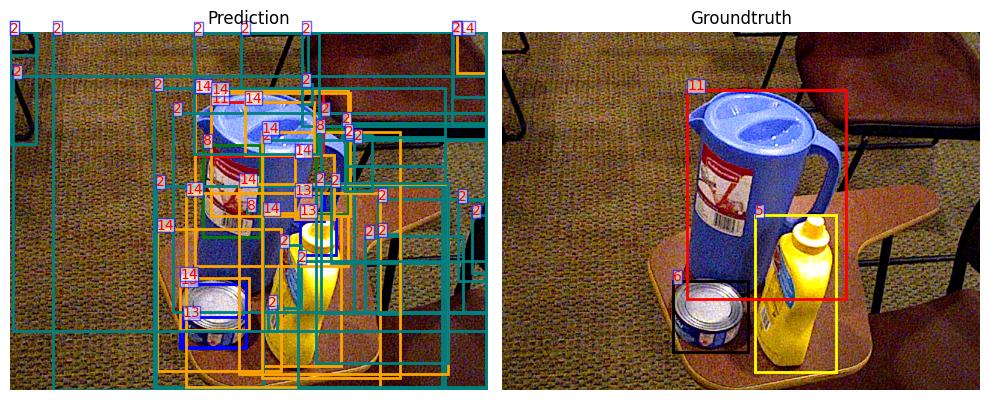

In [76]:
image_id = 1
ann_pred = list(filter(lambda json_results: json_results['image_id'] == image_id, json_results))
gt_annotations = gt_json_results['annotations']
ann_gt = list(filter(lambda gt_annotations: gt_annotations['image_id'] == image_id, gt_annotations))
img_file_name = gt_json_results['images'][image_id - 1]['file_name']
img_file_name = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/' + img_file_name
image = Image.open(img_file_name)
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,20))
ax = ax.ravel()
# ann_ids = coco.get_annIds(im)
# annotations = coco.load_anns(ann_ids)
for ann in ann_pred:
    bbox = ann['bbox']
    x, y, w, h = [int(b) for b in bbox]
    class_id = ann["category_id"]
    color_ = color_list[class_id]
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
    t_box=ax[0].text(x, y, str(class_id),  color='red', fontsize=10)
    t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
    ax[0].add_patch(rect)

ax[0].axis('off')
ax[0].imshow(image)
ax[0].set_xlabel('Longitude')
ax[0].set_title(f"Prediction")

for ann in ann_gt:
    bbox = ann['bbox']
    x, y, w, h = [int(b) for b in bbox]
    class_id = ann["category_id"]
    color_ = color_list[class_id]
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
    t_box=ax[1].text(x, y, str(class_id),  color='red', fontsize=10)
    t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
    ax[1].add_patch(rect)

ax[1].axis('off')
ax[1].imshow(image)
ax[1].set_xlabel('Longitude')
ax[1].set_title(f"Groundtruth")
plt.tight_layout()
plt.show()

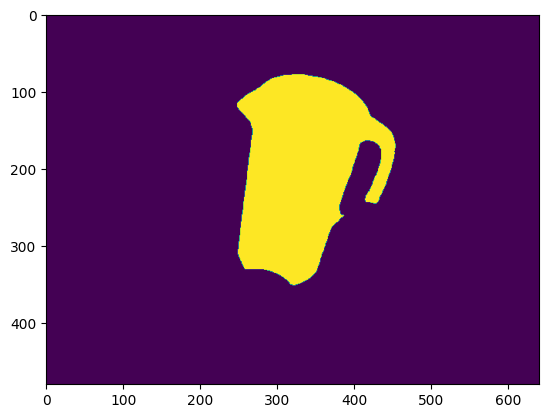

In [51]:
plt.imshow(masks[411])

In [52]:
import json
ann_file = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/scene_gt_coco_all.json'
with open (ann_file, 'r') as f:
    ann = json.load(f)

In [62]:
map_ann = ann
ind = 0
prev_filename = None
old_id = []
new_id = []
new_images_info = []
for info in ann['images']:
    img_id = info['id']
    img_filename = info['file_name']
    if (prev_filename is None) or (img_filename != prev_filename):
        ind += 1
        new_info = info
        new_info['id'] = ind
        new_images_info.append(new_info)
    old_id.append(img_id)
    new_id.append(ind)
    prev_filename = img_filename
for ann_info in map_ann['annotations']:
    ann_info['image_id'] = new_id[ann_info['image_id'] - 1]
map_ann['images'] = new_images_info

In [64]:
with open('/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/new_scene_gt_coco_all.json', 'w') as fout:
    json.dump(map_ann , fout)

In [63]:
map_ann['annotations'][:4]

[{'id': 1,
  'image_id': 1,
  'category_id': 5,
  'iscrowd': 0,
  'area': 14800,
  'bbox': [338, 245, 108, 210],
  'segmentation': {'counts': [162634,
    5,
    468,
    22,
    453,
    30,
    447,
    37,
    439,
    44,
    433,
    49,
    427,
    56,
    421,
    61,
    416,
    66,
    410,
    5,
    5,
    62,
    405,
    8,
    1,
    68,
    402,
    79,
    397,
    85,
    392,
    89,
    389,
    93,
    384,
    97,
    379,
    102,
    375,
    106,
    371,
    111,
    366,
    115,
    361,
    120,
    357,
    124,
    352,
    129,
    348,
    133,
    343,
    138,
    339,
    142,
    335,
    146,
    331,
    150,
    328,
    153,
    324,
    156,
    322,
    159,
    316,
    164,
    313,
    167,
    310,
    171,
    306,
    174,
    304,
    176,
    303,
    23,
    1,
    153,
    302,
    23,
    3,
    152,
    301,
    23,
    3,
    153,
    300,
    23,
    4,
    153,
    299,
    181,
    299,
    181,
    298,
    182,
    298,
    

In [46]:
new_id[:100]

[1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 10,
 11,
 11,
 11,
 12,
 12,
 12,
 13,
 13,
 13,
 14,
 14,
 14,
 15,
 15,
 15,
 16,
 16,
 16,
 17,
 17,
 17,
 18,
 18,
 18,
 19,
 19,
 19,
 20,
 20,
 20,
 21,
 21,
 21,
 22,
 22,
 22,
 23,
 23,
 23,
 24,
 24,
 24,
 25,
 25,
 25,
 26,
 26,
 26,
 27,
 27,
 27,
 28,
 28,
 28,
 29,
 29,
 29,
 30,
 30,
 30,
 31,
 31,
 31,
 32,
 32,
 32,
 33,
 33,
 33,
 34]

In [52]:
img_id = dataset.data_infos[0]['image_id']
img_file_name = img_metas[0]['ori_filename']
for i in range(bboxes.shape[0]):
    data = dict()
    data['image_id'] = img_id
    data['bbox'] = self.xyxy2xywh(bboxes[i])
    data['score'] = float(bboxes[i][4])
    data['category_id'] = id
    json_results.append(data)

In [108]:
det_bboxes = []
det_labels = []
inds = []
raw_score = []
# for i in range(len(proposals)):
det_bbox, det_label, ind = model.roi_head.bbox_head.get_bboxes(
    rois,
    cls_score[i],
    bbox_pred[i],
    bbox_score[i],
    contra_logits[i],
    rpn_score[i],
    img_shapes[i],
    scale_factors[i],
    rescale=rescale,
    cfg=rcnn_test_cfg)
    # det_bboxes.append(det_bbox)
    # det_labels.append(det_label)
    # inds.append(ind)
    # raw_score.append(cls_score[i])

tensor([[397.9998, 113.7888, 697.3149, 597.7299],
        [617.8714, 415.1472, 765.0414, 637.4359],
        [661.8751, 427.2849, 739.6099, 512.1434],
        ...,
        [691.0608, 429.4966, 731.5973, 460.1967],
        [145.9633, 664.5574, 346.0943, 800.1478],
        [510.7144,  54.6408, 646.5073, 168.5441]], device='cuda:4',
       grad_fn=<ViewBackward0>)

In [40]:
sim = torch.matmul(roi_feats, supp_roi_feats[0].T)

In [55]:
sim[411]

tensor([-0.1327,  0.0521, -0.2740, -0.5075, -0.4764, -0.4570, -0.3966, -0.0731,
        -0.6294, -0.3724, -0.1731, -0.5234, -0.0934, -0.0494, -0.5767, -0.1370,
        -0.6777, -0.3733, -0.3403, -0.3056,  0.0082], device='cuda:4')

In [41]:
dataset.coco.load_imgs(21)

[{'id': 21,
  'file_name': '000052/rgb/000057.png',
  'width': 640,
  'height': 480,
  'date_captured': '2022-10-11 00:39:32.334604',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''}]

In [29]:
anns = dataset.coco.getAnnIds(19)
dataset.coco.load_anns(anns)

[{'id': 19,
  'image_id': 19,
  'category_id': 5,
  'iscrowd': 0,
  'area': 14990,
  'bbox': [341, 256, 111, 216],
  'segmentation': {'counts': [164098,
    4,
    464,
    20,
    457,
    29,
    447,
    36,
    441,
    43,
    433,
    49,
    428,
    54,
    423,
    60,
    417,
    65,
    412,
    70,
    407,
    11,
    4,
    59,
    403,
    8,
    1,
    70,
    398,
    83,
    397,
    85,
    389,
    92,
    385,
    96,
    381,
    101,
    376,
    105,
    372,
    109,
    368,
    114,
    363,
    118,
    359,
    122,
    355,
    126,
    350,
    131,
    346,
    135,
    342,
    138,
    341,
    140,
    339,
    141,
    336,
    145,
    332,
    148,
    326,
    154,
    323,
    157,
    320,
    160,
    317,
    163,
    314,
    166,
    311,
    169,
    308,
    172,
    305,
    175,
    302,
    1,
    10,
    167,
    300,
    180,
    298,
    182,
    297,
    183,
    296,
    184,
    296,
    184,
    295,
    185,
    294,
    186,
 

In [15]:
img_metas

[{'filename': '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/000052/rgb/000057.png',
  'ori_filename': '000052/rgb/000057.png',
  'ori_shape': (480, 640, 3),
  'img_shape': (800, 1067, 3),
  'pad_shape': (800, 1088, 3),
  'scale_factor': array([1.6671875, 1.6666666, 1.6671875, 1.6666666], dtype=float32),
  'flip': False,
  'flip_direction': None,
  'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
   'std': array([58.395, 57.12 , 57.375], dtype=float32),
   'to_rgb': True}}]

In [42]:
THRESHOLD = 0.8
valid_inds = torch.where(torch.max(sim, dim=1)[0] > THRESHOLD)

In [50]:
torch.max(sim, dim=1)[0]

tensor([0.1887, 0.1887, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501,
        0.1501, 0.1501, 0.1501, 0.1397, 0.1397, 0.1392, 0.1073, 0.2602, 0.2608,
        0.2608, 0.2608, 0.2602, 0.2602, 0.2602, 0.3290, 0.3012, 0.1887, 0.1963,
        0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501,
        0.1501, 0.1501, 0.1501, 0.1242, 0.2608, 0.2602, 0.2608, 0.2608, 0.2608,
        0.2602, 0.2602, 0.2602, 0.2608, 0.3028, 0.1501, 0.1501, 0.1501, 0.1501,
        0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501,
        0.1501, 0.1501, 0.2602, 0.2602, 0.2602, 0.2602, 0.2602, 0.2602, 0.2602,
        0.2602, 0.2602, 0.3061, 0.3021, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501,
        0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1499, 0.1501,
        0.2602, 0.2602, 0.2602, 0.2602, 0.2602, 0.2602, 0.2602, 0.2602, 0.2602,
        0.2822, 0.2995, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501,
        0.1501, 0.1501, 0.1501, 0.1501, 

In [27]:
sim[0]

tensor([ 0.3467,  0.1482, -0.0012, -0.0127, -0.0840,  0.2454,  0.4173,  0.3492,
         0.3865,  0.0684,  0.4860, -0.0499,  0.0563,  0.0702, -0.0432, -0.0917,
         0.2835, -0.1087, -0.0306, -0.0470, -0.0445], device='cuda:4')

In [28]:
torch.max(sim, dim=1)[1][torch.max(sim, dim=1)[0] > THRESHOLD]

tensor([ 4,  4,  4,  4, 17,  4, 17, 17,  4,  4,  4, 17,  4, 17,  4, 17,  4,  4,
        17,  4,  4,  4,  4, 17, 17,  4,  4,  4,  4,  4, 17,  4,  4,  4,  4,  4,
         4,  4, 17, 17,  4, 17,  4], device='cuda:4')

In [21]:
rois[:100]

tensor([[   0.0000,  400.0000,  125.0000,  700.0000,  600.0000],
        [   0.0000,  656.5602,  426.3728,  741.4432,  514.5278],
        [   0.0000,  627.1941,  422.8842,  752.5997,  656.6280],
        [   0.0000,  663.0919,  426.2428,  743.4928,  522.1907],
        [   0.0000,  628.5383,  412.7589,  752.8212,  667.4188],
        [   0.0000,  656.3240,  426.8421,  740.8942,  520.4453],
        [   0.0000,  656.1880,  423.6972,  741.2498,  510.4466],
        [   0.0000,  648.3214,  428.4098,  738.9614,  514.2388],
        [   0.0000,  669.8616,  428.1377,  747.2497,  518.5355],
        [   0.0000,  672.0469,  425.8344,  746.3989,  526.5634],
        [   0.0000,  627.8176,  419.4271,  753.4118,  675.6821],
        [   0.0000,  661.8574,  423.6472,  741.7071,  511.9561],
        [   0.0000,  648.2292,  430.4629,  739.1880,  518.4221],
        [   0.0000,  648.7217,  425.0371,  737.3465,  510.3996],
        [   0.0000,  639.3042,  423.5298,  759.3311,  658.3832],
        [   0.0000,  663.

In [33]:
rois[valid_inds]

tensor([[  0.0000, 611.0843, 419.8825, 741.7309, 667.1262],
        [  0.0000, 609.8290, 423.7853, 741.7881, 668.5138],
        [  0.0000, 620.0327, 425.5507, 747.9572, 666.0912],
        [  0.0000, 622.4934, 422.2626, 746.9427, 665.8640],
        [  0.0000, 827.3416, 302.0530, 899.3457, 399.7922],
        [  0.0000, 579.3135, 417.7700, 751.1423, 722.5936],
        [  0.0000, 824.5927, 307.0980, 897.0402, 404.3828],
        [  0.0000, 821.9899, 310.5502, 896.9690, 407.5443],
        [  0.0000, 612.4870, 422.5752, 741.8160, 668.6278],
        [  0.0000, 600.7135, 425.4208, 730.2239, 675.0649],
        [  0.0000, 601.6513, 419.4274, 732.1960, 672.0112],
        [  0.0000, 830.4749, 295.1327, 904.5135, 389.5294],
        [  0.0000, 681.2929, 442.8216, 726.2108, 481.5341],
        [  0.0000, 829.6488, 301.7344, 903.7763, 396.1793],
        [  0.0000, 677.9371, 440.2729, 723.8476, 478.0762],
        [  0.0000, 818.4996, 304.2354, 897.1170, 401.8549],
        [  0.0000, 608.1635, 436.9503, 7

In [54]:
bbox_pred_decode[valid_inds]

tensor([[661.8751, 427.2849, 739.6099, 512.1434],
        [466.8885, 279.8887, 578.7310, 342.9688],
        [466.3263, 280.1706, 577.5729, 342.8038],
        [669.1934, 426.8380, 742.0455, 517.2111],
        [469.6339, 287.7520, 576.2740, 346.9287],
        [624.2393, 542.0185, 654.7086, 635.8085],
        [470.6292, 287.4321, 574.2366, 347.1162],
        [624.4608, 543.6543, 656.2804, 639.1694],
        [659.0042, 428.6526, 742.2692, 511.7761],
        [630.3853, 566.4467, 658.0064, 642.0764],
        [630.5844, 568.3063, 657.7101, 640.3337],
        [671.9753, 426.6866, 741.8464, 509.4359],
        [662.6862, 426.9615, 738.9326, 517.2956],
        [625.2429, 547.0135, 658.5486, 643.2013],
        [658.6967, 428.0542, 740.3273, 511.0527],
        [630.6248, 565.7813, 657.3910, 637.9212],
        [631.1809, 571.2105, 657.2202, 640.7551],
        [467.4857, 279.1873, 580.1091, 343.4890],
        [662.7545, 430.0840, 739.9388, 521.3674],
        [651.5480, 420.1835, 748.6606, 529.5032],


In [21]:
sim[torch.where(sim > 0.5)[0]]

tensor([[0.0615, 0.2031, 0.7472,  ..., 0.0039, 0.0050, 0.0175],
        [0.0615, 0.2031, 0.7472,  ..., 0.0039, 0.0050, 0.0175],
        [0.0615, 0.2031, 0.7472,  ..., 0.0039, 0.0050, 0.0175],
        ...,
        [0.0812, 0.0217, 0.0212,  ..., 0.6354, 0.6311, 0.1169],
        [0.0812, 0.0217, 0.0212,  ..., 0.6354, 0.6311, 0.1169],
        [0.0812, 0.0217, 0.0212,  ..., 0.6354, 0.6311, 0.1169]],
       device='cuda:4')

In [22]:
temperature = 0.2
similarity = torch.div(
    sim, temperature)
# for numerical stability
# sim_row_max, _ = torch.max(similarity, dim=1, keepdim=True)
# similarity = similarity - sim_row_max.detach()

# mask out self-contrastive
# logits_mask = torch.ones_like(similarity)
# logits_mask.fill_diagonal_(0)

exp_sim = torch.exp(similarity)
log_prob = similarity - torch.log(exp_sim.sum(dim=1, keepdim=True))

# per_label_log_prob = (log_prob * logits_mask * label_mask)

In [23]:
exp_sim.shape

torch.Size([500, 21])

In [24]:
log_prob.min()

tensor(-5.1724, device='cuda:4')

In [25]:
cls_score = exp_sim / exp_sim.sum(dim=1, keepdim=True)

In [26]:
exp_sim.sum(dim=1, keepdim=True).shape

torch.Size([500, 1])

In [27]:
cls_score[0]

tensor([0.0098, 0.0199, 0.3016, 0.0243, 0.2269, 0.0090, 0.0348, 0.0235, 0.0370,
        0.1479, 0.0086, 0.0620, 0.0142, 0.0136, 0.0128, 0.0104, 0.0133, 0.0080,
        0.0073, 0.0074, 0.0079], device='cuda:4')

In [31]:
torch.sum(cls_score > 0.3)

tensor(25, device='cuda:4')

In [32]:
cls_score[0]

tensor([0.0098, 0.0199, 0.3016, 0.0243, 0.2269, 0.0090, 0.0348, 0.0235, 0.0370,
        0.1479, 0.0086, 0.0620, 0.0142, 0.0136, 0.0128, 0.0104, 0.0133, 0.0080,
        0.0073, 0.0074, 0.0079], device='cuda:4')

In [54]:
cls_score.max(dim=1)[0][cls_score.max(dim=1)[0] > 0.3]

tensor([0.3016, 0.3165, 0.3356, 0.3301, 0.3439, 0.3280, 0.3085, 0.3056, 0.3760,
        0.3482, 0.3730, 0.3329, 0.3504, 0.3298, 0.3591, 0.3807, 0.3545, 0.3764,
        0.3809, 0.3408, 0.3408, 0.3747, 0.3323, 0.3501, 0.3096],
       device='cuda:4')

In [53]:
cls_score.max(dim=1)[1][cls_score.max(dim=1)[0] > 0.3]

tensor([ 2,  2, 18,  2, 18, 18, 18, 18,  4, 18,  4,  4, 18, 18, 18,  4, 18,  4,
        18, 18,  4, 18, 18,  4,  4], device='cuda:4')

In [144]:
log_prob.min()

tensor(-1.1921e-07, device='cuda:4')

In [126]:
rois[torch.where(sim > 0.5)[0]]

tensor([], device='cuda:4', size=(0, 5))

In [127]:
proposals[0][torch.where(sim > 0.5)[0]]

tensor([], device='cuda:4', size=(0, 5))

In [115]:
rois[297]

tensor([  0.0000, 574.8376, 558.4380, 713.0351, 736.8537], device='cuda:4')

In [116]:
rois.shape

torch.Size([2000, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


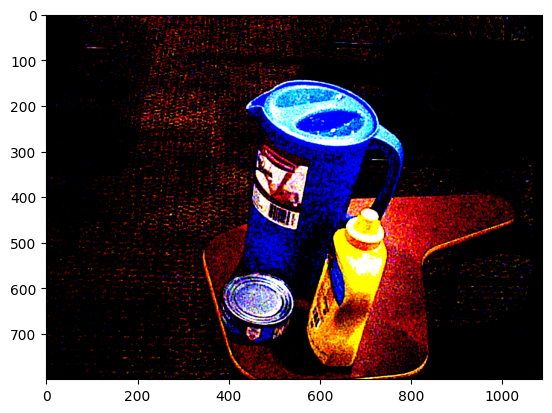

In [24]:
plt.imshow(batch['img'][0][0].permute(1,2,0).cpu())

In [70]:
import pickle
with open('/home/minhnh/project_drive/CV/VehicleSpeedEstimation/data/2016-ITS-BrnoCompSpeed/dataset/session2_center/gt_data.pkl', 'rb') as f:
    a = pickle.load(f, encoding='latin1')

In [71]:
a

{'distanceMeasurement': [{'p2': array([417.55957895, 266.36906371,   1.        ]),
   'distance': 7.018,
   'toVP1': True,
   'p1': array([458.85447091, 179.46285503,   1.        ])},
  {'p2': array([368.79955679, 389.46133333,   1.        ]),
   'distance': 6.996,
   'toVP1': True,
   'p1': array([417.55957895, 266.36906371,   1.        ])},
  {'p2': array([276.36299169, 573.06060942,   1.        ]),
   'distance': 7.012,
   'toVP1': True,
   'p1': array([368.79955679, 389.46133333,   1.        ])},
  {'p2': array([129.11069252, 875.62802585,   1.        ]),
   'distance': 7.006,
   'toVP1': True,
   'p1': array([276.36299169, 573.06060942,   1.        ])},
  {'p2': array([1.14622404e+03, 1.48957488e+02, 1.00000000e+00]),
   'distance': 27.886,
   'toVP1': True,
   'p1': array([1.68473033e+03, 7.81073729e+02, 1.00000000e+00])},
  {'p2': array([657.16334626, 170.36906371,   1.        ]),
   'distance': 7.965,
   'toVP1': False,
   'p1': array([1.14622404e+03, 1.48957488e+02, 1.00000000

In [121]:
from PIL import Image
import numpy as np
def read_image(filepath):
    # Open the image file
    img = Image.open(filepath)
    # Convert the image to a Numpy array
    img_array = np.array(img)
    # Display the array
    return img_array

In [124]:
img_id = 1
obj_id = 6
img_path = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/000052/rgb/{:06d}.png'.format(img_id)
obj_path = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_{:06d}/rgb/000010.jpg'.format(obj_id)

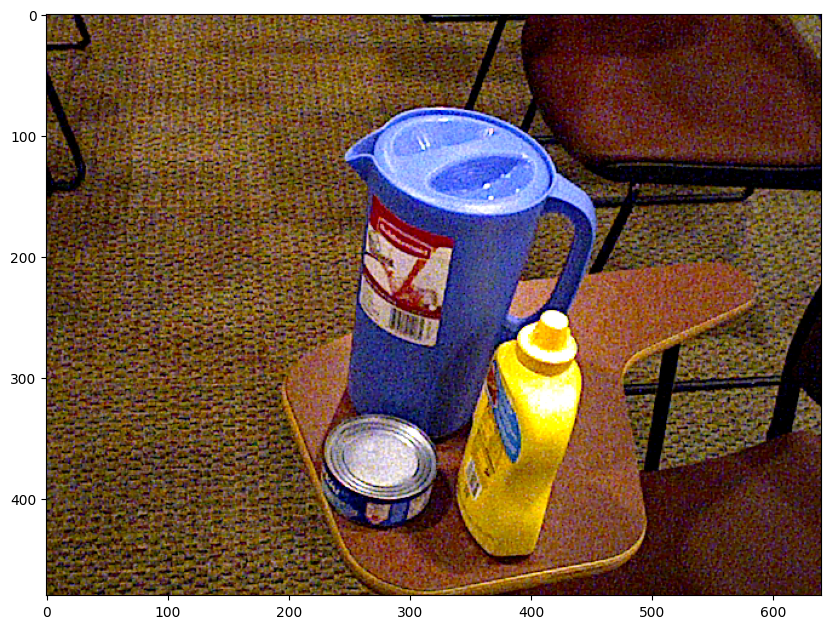

In [31]:
plt.figure(figsize=(10,15))
plt.imshow(read_image(img_path))

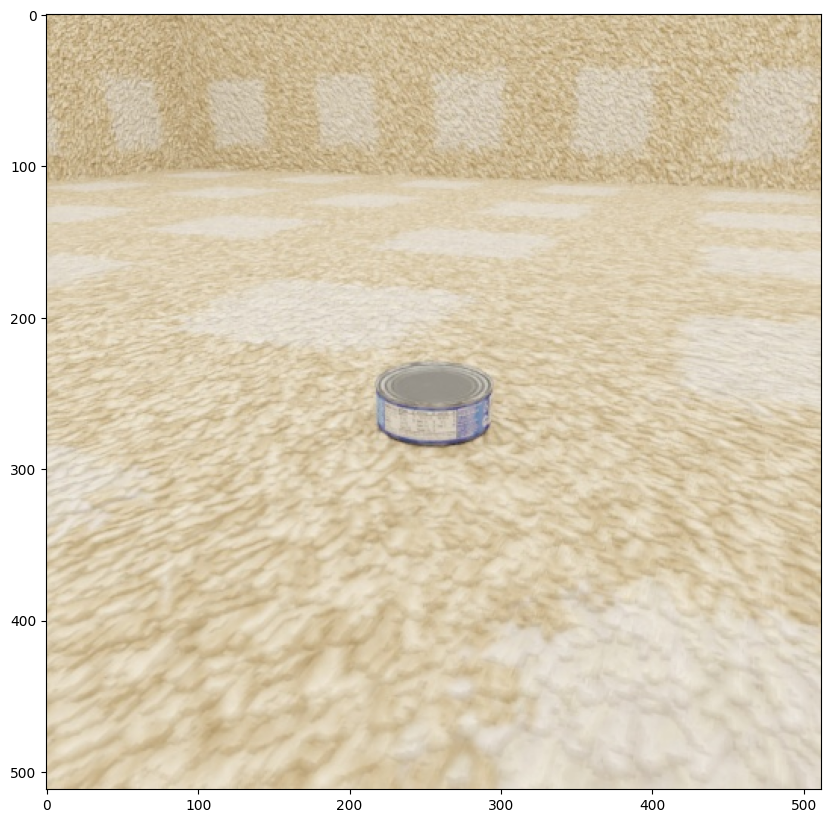

In [125]:
plt.figure(figsize=(10,15))
plt.imshow(read_image(obj_path))

In [ ]:
dataset.evaluate(results, jsonfile_prefix='results')

In [88]:
batch

{'img_metas': [[{'filename': '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/000052/rgb/000057.png',
    'ori_filename': '000052/rgb/000057.png',
    'ori_shape': (480, 640, 3),
    'img_shape': (800, 1067, 3),
    'pad_shape': (800, 1088, 3),
    'scale_factor': array([1.6671875, 1.6666666, 1.6671875, 1.6666666], dtype=float32),
    'flip': False,
    'flip_direction': None,
    'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
     'std': array([58.395, 57.12 , 57.375], dtype=float32),
     'to_rgb': True}}]],
 'img': [tensor([[[[-1.3815, -1.3815, -1.3987,  ...,  0.0000,  0.0000,  0.0000],
            [-1.3130, -1.3130, -1.2788,  ...,  0.0000,  0.0000,  0.0000],
            [-1.2274, -1.1760, -1.1075,  ...,  0.0000,  0.0000,  0.0000],
            ...,
            [-0.7822, -0.8335, -0.9020,  ...,  0.0000,  0.0000,  0.0000],
            [-0.3027, -0.5253, -0.8678,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0227, -0.3198, -0.8335,  

In [24]:
from repvit_sam import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

In [25]:
image = batch['img'][0][0]

In [27]:
c, h, w = image.shape

In [29]:
xvalues = np.linspace(0, w, 25, dtype='int')
yvalues = np.linspace(0, h, 25, dtype='int')
xx, yy = np.meshgrid(xvalues, yvalues)
positions = np.column_stack([xx.ravel(), yy.ravel()]).astype(int)

In [15]:
bboxes = model.rpn_sam(batch['img_metas'][0])

In [18]:
from PIL import Image

In [25]:
filepath = batch['img_metas'][0][0]['filename']
image = Image.open(filepath)
plt.imshow(np.array(batch['img'][0][0].permute(1, 2, 0).c))

TypeError: can't convert cuda:4 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [24]:
batch['img'][0].shape

torch.Size([1, 3, 800, 1088])